# Predicting Sin Wave by using Simple RNN

In this notebook, you will understand how RNN can predict sin wave. We are going to use [Keras](https://keras.io/), a high-level API for deep learning, which is a wrapper of TensorFlow, CNTK, or Theano. Keras was developed with a focus on enabling fast experimentation, which makes this framework easy to use and learn deep learning.

In order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., create_window). We are not going to discuss the implementation aspects of these functions here, but you can to explore and read the content of the functions later on.

Summary:
 - [Creating sin data](#create)
 - [Creating the Windowed Data Set](#window)
 - [Building the Model](#model)
     - [Data Pre-processing](#process)
     - [Spliting the Data into Training and Test Dataset](#split)
     - [Basic RNN Model](#rnn)
     - [Using the history](#hist)
     - [Prediction and Performance Analysis](#performance)
 - [Model Understanding: What are the model weights and hidden units?](#model_understanding)


__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

In [1]:
# Standard libraries - no deep learning yet
import math # standard library, provides functions such as for trigonometry and logarithms as well as constants.
import numpy as np # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting

from utils import * # this will load all the utils functions implements for this tutorial

# the following to lines will tell to the python kernel to alway update the kernel for every utils.py
# modification, without the need of restarting the kernel.
# Of course, for every motification in util.py, we need to reload this cell
%load_ext autoreload
%autoreload 2

# If you see some RuntimeWarning, just ignore them.

Using TensorFlow backend.


## Creating sin data
<a id='create'></a>

The function __create_sin_data__ (see **utils.py**) uses the function [np.sin](https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.sin.html) from numpy and store the data in a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) format.

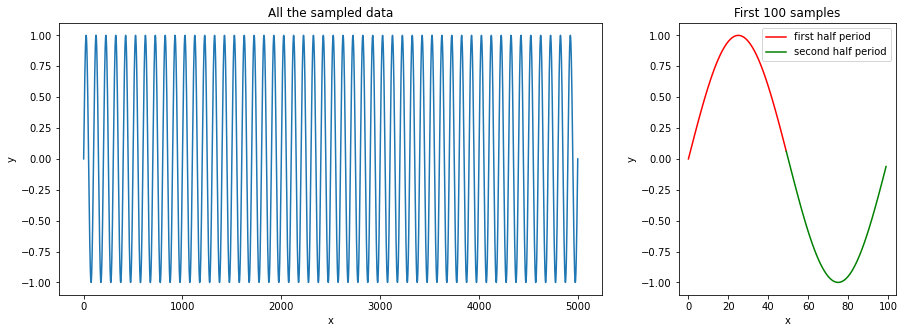

In [15]:
# Creating the sin data, this returns a DataFrame
series = create_sin_data(samples=5000, period=50)

# Visualising the series
f, (ax0, ax1) = plt.subplots(1,2, figsize = (15, 5), gridspec_kw = {'width_ratios':[5, 2]})

# Ploting the sampled data
   # series.values returns a numpy representation of the DataFrame
ax0.plot(series.values)
ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_title("All the sampled data")

# Ploting the first PERIOD of the sampled data
  # series.values returns a numpy representation of the DataFrame, by doing series.values[:PERIOD], we are 
  # taking the first 50 samples in the numpy.array representation
ax1.plot(range(50),series.values[:50], 'r', label='first half period')
ax1.set_xlabel("x")
ax1.set_ylabel("y")


  # series.values returns a numpy representation of the DataFrame, by doing series.values[:PERIOD], we are 
  # taking the second 50 samples in the numpy.array representation
ax1.plot(range(49, 100), series.values[49:100], 'g', label='second half period')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("First {} samples".format(100))
ax1.legend(loc="upper right")

plt.show()

## Creating the Windowed Data Set
<a id='window'></a>

To window the dataset, we wrote the function __create_window__ (see _utils.py_), this fixes _window_\__size_ and  uses pandas [shift](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) function. The function shifts an entire column by a given number. In our case, we shifted the column up by 1 and then concatenate that to the original data. For example, if window_size is 5, we will use the first 4 elements and predict the next one. Therefore, we each row is on sample traning.

In [3]:
# Performing the sliding window (window_size=5) with drop_nan = False. 
series_backup = series.copy()
t = create_window_sin(series_backup, window_size = 5)
# show the last 5 elements in the DataFrame (dataframe.tail can be used for this propose)
t.tail()

,0,0,0,0,0,0
4995,-2.487386e-01,-1.874184e-01,-1.253582e-01,-6.280306e-02,9.821934e-16,NaN
4996,-1.874184e-01,-1.253582e-01,-6.280306e-02,9.821934e-16,NaN,NaN
4997,-1.253582e-01,-6.280306e-02,9.821934e-16,NaN,NaN,NaN
4998,-6.280306e-02,9.821934e-16,NaN,NaN,NaN,NaN
4999,9.821934e-16,NaN,NaN,NaN,NaN,NaN


As you can see in the table above, a lot of NaN where included in the dataset, in order to remove these value we will set _drop_nan_ = True. This will allow us to use pandas function [dropna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html)

In [4]:
# Performing the sliding window (window_size=5) with drop_nan = True. 
series_backup = series.copy()
t = create_window_sin(series_backup, window_size = 5, drop_nan=True)
# print the last 5 elements in the DataFrame (dataframe.tail can be used for this propose)
t.tail()

,0,0,0,0,0,0
4990,-0.535922,-0.481842,-0.425859,-0.368195,-0.309077,-2.487386e-01
4991,-0.481842,-0.425859,-0.368195,-0.309077,-0.248739,-1.874184e-01
4992,-0.425859,-0.368195,-0.309077,-0.248739,-0.187418,-1.253582e-01
4993,-0.368195,-0.309077,-0.248739,-0.187418,-0.125358,-6.280306e-02
4994,-0.309077,-0.248739,-0.187418,-0.125358,-0.062803,9.821934e-16


For now, we can ignore the **column_names** (they are all zero). They will not play any role in this tutorial, however, if you would like to change them,| click in [this link](https://chrisalbon.com/python/data_wrangling/pandas_rename_multiple_columns/) for more information.

In [5]:
# Print the first 5 elements by using dataframe.head()
t.head()

,0,0,0,0,0,0
0,-9.821934e-16,0.062803,0.125358,0.187418,0.248739,0.309077
1,6.280306e-02,0.125358,0.187418,0.248739,0.309077,0.368195
2,1.253582e-01,0.187418,0.248739,0.309077,0.368195,0.425859
3,1.874184e-01,0.248739,0.309077,0.368195,0.425859,0.481842
4,2.487386e-01,0.309077,0.368195,0.425859,0.481842,0.535922


# Building the Model
<a id='model'></a>

So far, we just created the dataset and showed how we can use pandas for data manipulation. Now, we are going to preprocess the data and build a __simple RNN__ model. 

In [6]:
# Loading the libraries required for this step.
# keras components, we will describe each one along this tutorial, so don't be worry 
from keras.models import Sequential
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Activation

# Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler # allows normalisation
from sklearn.metrics import mean_squared_error # allows compute the mean square error to performance analysis

## Data Pre-processing
<a id='process'></a>

Normalising the data on the (-1,1) interval by using the function [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [7]:
# creating the dataset
series = create_sin_data(samples=5000, period=50)

# normalising the data
scaler = MinMaxScaler(feature_range = (-1, 1)) 

# Note that below we are normalising the series.values (numpy array data) and not 
# series (DataFrame data)
scaled = scaler.fit_transform(series.values) 

# Convert scaled (numpy.array) to DataFrame.
series = pd.DataFrame(scaled)

In [8]:
# Windowing the dataset
window_size = 50

# you can also try drop_nan = False just to see the series_w.tail() result.
series_w = create_window_sin(series, window_size, drop_nan = True)

# Visualising the first 5 samples
series_w.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-9.821934e-16,0.062803,0.125358,0.187418,0.248739,0.309077,0.368195,0.425859,0.481842,0.535922,...,0.535392,0.481291,0.425290,0.367610,0.308479,0.248130,0.186801,0.124735,0.062176,-0.000628
1,6.280307e-02,0.125358,0.187418,0.248739,0.309077,0.368195,0.425859,0.481842,0.535922,0.587887,...,0.481291,0.425290,0.367610,0.308479,0.248130,0.186801,0.124735,0.062176,-0.000628,-0.063430
2,1.253582e-01,0.187418,0.248739,0.309077,0.368195,0.425859,0.481842,0.535922,0.587887,0.637531,...,0.425290,0.367610,0.308479,0.248130,0.186801,0.124735,0.062176,-0.000628,-0.063430,-0.125982
3,1.874184e-01,0.248739,0.309077,0.368195,0.425859,0.481842,0.535922,0.587887,0.637531,0.684657,...,0.367610,0.308479,0.248130,0.186801,0.124735,0.062176,-0.000628,-0.063430,-0.125982,-0.188036
4,2.487386e-01,0.309077,0.368195,0.425859,0.481842,0.535922,0.587887,0.637531,0.684657,0.729081,...,0.308479,0.248130,0.186801,0.124735,0.062176,-0.000628,-0.063430,-0.125982,-0.188036,-0.249347


In [9]:
print("Shape of input data: {}".format(series_w.shape))

Shape of input data: (4950, 51)


## Spliting the Data into Training and Test Dataset
<a id='split'></a>

First we need to split our dataset into training and dataset, as described below.

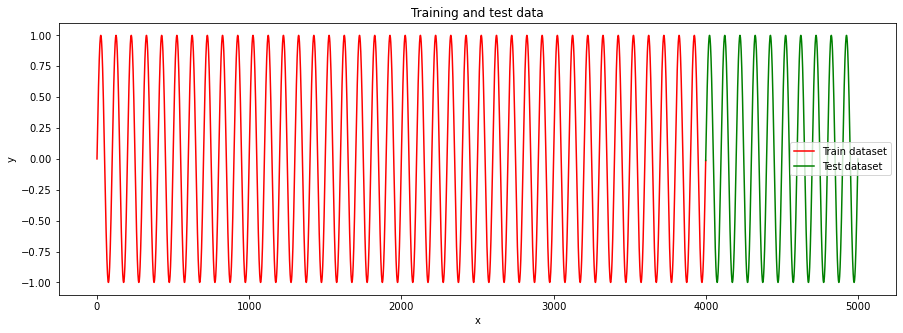

In [10]:
# First, let's visualise how our splitted dataset will like. For our better understading, 
# here we will plot the non-windowed data.

# we are using the function implemented in utils.py. We defined 80% to be used for training and 20% 
# for testing
plot_training_test_data(series, train_size=0.8)

In [11]:
# Spliting the data into 80% of data for training and 20% of data for testing
train_X, train_Y, test_X, test_Y = train_test_split(series_w, train_size=0.8)

print("Training set shape: :")
print("  - X (inputs)", train_X.shape)
print("  - Y (output):", train_Y.shape)
print("\nTresting set shape: :")
print("  - X (inputs)", test_X.shape)
print("  - Y (output):", test_Y.shape)

Training set shape: :
  - X (inputs) (3960, 50)
  - Y (output): (3960,)

Tresting set shape: :
  - X (inputs) (990, 50)
  - Y (output): (990,)


In [12]:
# The function train_test_split return 2D arrays, however, we will use tensor representation,
# in which the third dimension is the number of the batch. To fix the shape, we use 
# the numpy.reshape (https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)
# function, as follows 
train_X = np.reshape(train_X.values, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X.values, (test_X.shape[0], test_X.shape[1], 1))

print("Fixed shape: :")
print("  - Training dataset: ", train_X.shape)
print("  - Testing dataset: ", test_X.shape)

Fixed shape: :
  - Training dataset:  (3960, 50, 1)
  - Testing dataset:  (990, 50, 1)


Note that now _train_\__X_ and _text_\__X_ are numpy.array.

## Basic RNN Model
<a id='rnn'></a>

You are going to build a model based on a simple (basic) RNN. This model consists in a **many_to_one** architecture, in which our input is the **window_size** and our output is the predicted value (dimension 1). 

To build the model, you are going to use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [SimpleRNN](https://keras.io/layers/recurrent/): provides a Basic (simple) RNN architecture
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Activation](https://keras.io/activations/): defines the activation function to be used

Basically, we will defined the sequence of our model by using _Sequential()_, include the layers:

```
    model = Sequential()
    model.add(SimpleRNN(...))
    ...
```
once created the model we can configure the model for training by using the method [compile](https://keras.io/models/model/). Here we need to define the [loss](https://keras.io/losses/) function (mean squared error, mean absolute error, cosine proximity, among others.), the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others) and the [metric](https://keras.io/metrics/) to define the evaluation metric to be used to evaluate the performance of the model in the training step, as follows:

```python
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of the model by using the function [summary](https://keras.io/models/about-keras-models/#about-keras-models). This function summarise the model and tell us the number of parameters that we need to tune.

In [13]:
# Define the model.
model_rnn = Sequential()

# The input shape is the number of inputs per windows size (windows_size,1)
# we will need to define the number of units.

# The activation function for each cell, by default, is 'tanh' (activation='tanh').
# Finally, we need to set return_sequences = False (by default is True). This parameter
# is quite important because determines whether to return the last output in the output sequence, 
# or the full sequence. As we are using a many_to_one architecture, we are interested in the last
# output. Note that the output will be the same shape of the units, for instance if  units
# is equal 4, we will have an output array with four elements that represent the weights to be used
# by the fully-connect (dense) layer that will generate the predicted output (y_hat), see the code below.
model_rnn.add(SimpleRNN(input_shape = (window_size, 1), 
                        units = 64, # try here with 2 or 4 units and check the performance of the model
                        return_sequences = False))
model_rnn.add(Dense(units=1)) # in which units is dimensionality of the output space, our case 1 
                              # (we will predict the next value). By default, the activation function is 
                              # linear

# just print the model
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


**Exercise:** Define optimiser (try 'rmsprop', 'sgd', 'adagrad' or 'adadelta' if you wich) and loss. As we are doing a regression task, the loss functions 'mae' (mean average error) and 'mse' (mean squared error) might be the choices.
  
For example:  
```python    
model_rnn.compile(loss = "mse", 
                  optimizer = "adam")
```

**Exercise:** As you already know, once defined the model, we need to train it by using the function [fit](https://keras.io/models/model/). This function performs the optmisation step. Hence, we can define the following parameters such as:

 - batch size: defines the number of samples that will be propagated through the network
 - epochs: defines the number of times in which all the training set (x_train_scaled) are used once to update the weights
 - validation split: defines the percentage of training data to be using for validation
 - among others (click [here](https://keras.io/models/model/) for more information)
 

For this exercise, define the number of epochs, validation_split and batch_size that best fit for you model and call the function fit to train the model.

For example:
```python
# training the model
history = model_rnn.fit(train_X, 
                          train_Y, 
                          batch_size = 512,
                          epochs = 10,
                          validation_split = 0.1,
                          shuffle=False)
```

### Using the history
<a id='hist'></a>

Here we can see if the model overfits or underfits. 

In [14]:
plot_loss(history)

NameError: name 'history' is not defined

### Prediction and Performance Analysis
<a id='performance'></a>

Once the model was trained, we can use the function [predict](https://keras.io/models/model/) for  prediction tasks.

In [ ]:
# Prediction on test data.
pred_test = model_rnn.predict(test_X)

# In order to use to right data, first we need to use the inverse transformation to get back true values. 
#We do this to converte the predictions back into their original scale.
# This can be done by using the method inverse_transform provided by the component MinMaxScaler
# (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

# Computing the mean squared error of of the test data against the predicted data
model_rnn_mse = mean_squared_error(test_y_actual, pred_test)
print("MSE for predicted test set: %2f" % model_rnn_mse)

### Visualising the predicted Data

Here, we are going to plot the test data against the the predicted data.

In [ ]:
plot_comparison([test_y_actual, pred_test], 
                ['Test_Y value','Predicted Value'], 
                title='Prediction Comparison')

## Model Understanding: What are the model weights and hidden units?
<a id='model_understanding'></a>

In order to understand the model, let's have a look the shapes of the weights and the hidden units.

For the SimpleRNN:
 - weights[0] is the input matrix and has a shape [input_dim, output_dim]
 - weights[1] is the weight matrix and has a shape [output_dim, output_dim]
 - weights[2] is the bias matrix and has a shape [output_dim]
 
For the fully-connected layer (Dense):
 - weights[0] is the weight matrix and has shape [output_dim, output_dim]
 - weights[1] is the bias matrix and has a shape [output_dim]
 
For the hidden units:
 - The shape must be the same shape of the test set, i.e., if the shape of the test set it 100 we will have 100 hidden units in the prediction stage

In [ ]:
print('Number of layers: ', len(model_rnn.layers))

weights = {}
layers = [] 
for layer in model_rnn.layers:
    weights[layer.name] = layer.get_weights()
    layers.append(layer.name)

hidden_units = model_rnn.predict(test_X).flatten()
    
print('Weights shape:')

# we know that we have just two layers: SimpleRNN and Dense
print(" ", layers[0])
print("    Input: ",weights[layers[0]][0].shape)
print("    Weights (W_hh): ",weights[layers[0]][1].shape)
print("    Bias (b_h): ",weights[layers[0]][2].shape)

print(" ", layers[1])
print("    Weights (W_yh): ",weights[layers[1]][0].shape)
print("    Bias (b_y): ",weights[layers[1]][1].shape)

print('\nHidden units shape: ', hidden_units.shape, ' and the shape of the test_X is ', test_X.shape[0])

# Another Way to Create Models

So far we see how create a RNN model in Keras by using the **Sequential** API. However, this API is limited, it does not allow us to create models that share layers or have multiple inputs or outputs. 
For example, it is not easy to define models that may have:

 - multiple different input sources,
 - produce multiple output destinations, or
 - models that re-use layers.
 
Another way to create a model is by using the [**Functional**](https://keras.io/getting-started/functional-api-guide/) API. This API allows us to create a more robust model, which more flexibility and fredoom do define and re-use layers. This allow us do define complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

The use of **Functional API** is beyond this tutorial, however it is well documented can be found [here](https://keras.io/getting-started/functional-api-guide/).